# 설정

In [11]:
# 파이썬 ≥ 3.5필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 캐글 산탄데르 고객 만족 예측

이번에는 캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터 세트에 대해서 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해 보겠다. 산탄데르 고객 만족 예측 분석은 370개의 피처로 주어진 데이터 세트 기반에서 고객 만족 여부를 예측하는 것이다. 산탄데르 은행이 캐글에 경연을 의뢰한 데이터로서 피처 이름은 모두 익명 처리돼 이름만을 가지고 어떤 속성인지는 추정할 수 없다. 클래스 레이블 명은 TARGET이며, 이 값이 1이면 불만을 가진 고객, 0이면 만족한 고객이다.

모델의 성능 평가는 ROC-AUC(ROC 곡선 영역)로 평가한다. 대부분이 만족이고 불만족인 데이터는 일부일 것이기 때문에 정확도 수치는 ROC-AUC가 더 적합하다.

## 데이터 전처리

데이터를 준비하고 필요한 모듈을 로딩하고 학습 데이터를 DataFrame으로 로딩한다. XGBoost는 사이킷런 래퍼를 이용할 것이다.

In [13]:
import pandas as pd

cust_df = pd.read_csv("./santander-customer-satisfaction/train.csv", encoding="latin-1")
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


클래스 값 칼럼을 포함한 피처가 371개 존재한다. 피처의 타입과 Null 값을 좀 더 알아보겠다.

In [14]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


111개의 피처가 float 형, 260개의 피처가 int 형으로 모든 피처가 숫자 형이며, Null 값은 없다. 전체 데이터에서 만족과 불만족의 비율을 살펴보겠다. 레이블인 Target 속성의 값의 분포를 알아보면 된다. 대부분이 만족이며 불만족인 고객은 얼마 되지 않는 4%에 불과한다.

In [15]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


DataFrame의 <code>describe()</code> 메서드를 이용해 각 피처의 값 분포를 간단히 확인해 보겠다.

In [17]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


클래스 레이블 포함 371개의 칼럼 중 348개의 칼럼이 0 값을 가장 많이 갖고 있다.

In [46]:
cust_df.apply(lambda x: x.value_counts().index[0]).value_counts()

0.000000         348
3.000000          10
1.000000           7
2.000000           2
23.000000          1
99.000000          1
117310.979016      1
dtype: int64

var3 칼럼의 경우 min 값이 -999999다. NaN이나 특정 예외 값을 -999999로 변환했을 것이다.

In [18]:
print(cust_df.var3.value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


-999999 값이 116개가 있다. var3은 숫자 형이고, 다른 값에 비해 -999999은 너무 편차가 심하므로 -999999를 가장 값이 많은 2로 변환하겠다. ID 피처는 단순 식별자에 불과하므로 피처를 드롭하겠다. 그리고 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장하겠다.

In [45]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리하겠다. 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인하겠다.

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, stratify=y_labels,
                                                    random_state=0)

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, y_train.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts(normalize=True))
print('테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts(normalize=True))

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(60816,)
학습 세트 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64
테스트 세트 레이블 값 분포 비율
0    0.960405
1    0.039595
Name: TARGET, dtype: float64


학습과 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값(값 1)으로 만들어졌다.

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

먼저 XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해 보겠다. 사이킷런 래퍼인 XGBClassifier를 기반으로 학습을 수행한다. n_estimators는 500으로 하되 early_stopping_rounds를 100으로 설정한다. 성능 평가 기준이 ROC-AUC이므로 XGBClassifier가 eval_metric은 'auc'로 하겠다(logloss로 해도 큰 차이는 없다). 그리고 평가 데이터 세트는 앞에서 분리한 테스트 데이터 세트를 이용하겠다. 사실 테스트 데이터 세트를 XGBoost의 평가 데이터 세트로 사용하면 과대적합의 가능성을 증가시킬 수 있지만, 여기서는 이러한 점만 주지하고 넘어가도록 하겠다.

In [55]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82569	validation_1-auc:0.79283
[1]	validation_0-auc:0.84010	validation_1-auc:0.80737
[2]	validation_0-auc:0.84361	validation_1-auc:0.81021
[3]	validation_0-auc:0.84783	validation_1-auc:0.81287
[4]	validation_0-auc:0.85123	validation_1-auc:0.81469
[5]	validation_0-auc:0.85518	validation_1-auc:0.81860
[6]	validation_0-auc:0.85922	validation_1-auc:0.81977
[7]	validation_0-auc:0.86238	validation_1-auc:0.82034
[8]	validation_0-auc:0.86570	validation_1-auc:0.82147
[9]	validation_0-auc:0.86798	validation_1-auc:0.82301
[10]	validation_0-auc:0.87104	validation_1-auc:0.82379
[11]	validation_0-auc:0.87448	validation_1-auc:0.82456
[12]	validation_0-auc:0.87687	validation_1-auc:0.82401
[13]	validation_0-auc:0.87918	validation_1-auc:0.82467
[14]	validation_0-auc:0.88081	validation_1-auc:0.82508
[15]	validation_0-auc:0.88331	validation_1-auc:0.82379
[16]	validation_0-auc:0.88569	validation_1-auc:0.82457
[17]	validation_0-auc:0.88675	validation_1-auc:0.82453
[18]	validation_0-au

테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8251이다.

다음으로는 XGBoost의 하이퍼 파라미터 튜닝을 수행해 보겠다. 칼럼의 개수가 많으므로 과대적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상으로 하겠다. 학습 시간이 많이 필요한 ML 모델인 경우 하이퍼 파라미터 튜닝을 수행하는 요령 중 첫 번째는 먼저 2\~3개 정도의 파라미터를 결합해 최적의 파라미터를 찾아낸 뒤에 이 최적의 파라미터를 기반으로 다시 1\~2개 파라미터를 결합해 파라미터 튜닝을 수행하는 것이다.

다음 예제 코드는 8개의 하이퍼 파라미터 경우의 수를 가진다. 수행 시간이 오래 걸리므로 n_estimators는 100으로 줄이고, early_stopping_rounds도 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 증가시키겠다. GridSearchCV 적용 후에 최적의 파라미터가 어떤 것이고, GridSearchCV에서 재학습된 Estimator에서 ROC-AUC 수치가 어떻게 향상됐는지 확인해 보겠다.

In [61]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth': [3, 4, 5, 6, 7], 'min_child_weight': [3, 4, 5, 6], 'colsample_bytree': [0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average="macro")
print("ROC AUC: {0:.4f}".format(xgb_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80745	validation_1-auc:0.78105
[1]	validation_0-auc:0.81030	validation_1-auc:0.78407
[2]	validation_0-auc:0.81379	validation_1-auc:0.78622
[3]	validation_0-auc:0.81544	validation_1-auc:0.78811
[4]	validation_0-auc:0.82092	validation_1-auc:0.79514
[5]	validation_0-auc:0.82726	validation_1-auc:0.80280
[6]	validation_0-auc:0.82739	validation_1-auc:0.80237
[7]	validation_0-auc:0.82875	validation_1-auc:0.80445
[8]	validation_0-auc:0.82985	validation_1-auc:0.80491
[9]	validation_0-auc:0.83420	validation_1-auc:0.80825
[10]	validation_0-auc:0.83424	validation_1-auc:0.80707
[11]	validation_0-auc:0.83422	validation_1-auc:0.80847
[12]	validation_0-auc:0.83927	validation_1-auc:0.81420
[13]	validation_0-auc:0.84091	validation_1-auc:0.81436
[14]	validation_0-auc:0.84229	validation_1-auc:0.81465
[15]	validation_0-auc:0.84395	validation_1-auc:0.81613
[16]	validation_0-auc:0.84518	validation_1-auc:0.81683
[17]	validation_0-auc:0.84624	validation_1-auc:0.81815
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80532	validation_1-auc:0.77772
[1]	validation_0-auc:0.80866	validation_1-auc:0.78039
[2]	validation_0-auc:0.81695	validation_1-auc:0.78860
[3]	validation_0-auc:0.81976	validation_1-auc:0.79252
[4]	validation_0-auc:0.82408	validation_1-auc:0.79846
[5]	validation_0-auc:0.82352	validation_1-auc:0.79682
[6]	validation_0-auc:0.82920	validation_1-auc:0.80298
[7]	validation_0-auc:0.83051	validation_1-auc:0.80298
[8]	validation_0-auc:0.83313	validation_1-auc:0.80582
[9]	validation_0-auc:0.83601	validation_1-auc:0.80723
[10]	validation_0-auc:0.83737	validation_1-auc:0.80843
[11]	validation_0-auc:0.83733	validation_1-auc:0.80623
[12]	validation_0-auc:0.84066	validation_1-auc:0.81139
[13]	validation_0-auc:0.84296	validation_1-auc:0.81467
[14]	validation_0-auc:0.84416	validation_1-auc:0.81529
[15]	validation_0-auc:0.84594	validation_1-auc:0.81639
[16]	validation_0-auc:0.84728	validation_1-auc:0.81710
[17]	validation_0-auc:0.84769	validation_1-auc:0.81763
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80200	validation_1-auc:0.77926
[1]	validation_0-auc:0.81623	validation_1-auc:0.79583
[2]	validation_0-auc:0.81803	validation_1-auc:0.79606
[3]	validation_0-auc:0.82048	validation_1-auc:0.79777
[4]	validation_0-auc:0.82054	validation_1-auc:0.79838
[5]	validation_0-auc:0.82427	validation_1-auc:0.80363
[6]	validation_0-auc:0.82732	validation_1-auc:0.80573
[7]	validation_0-auc:0.82828	validation_1-auc:0.80689
[8]	validation_0-auc:0.83003	validation_1-auc:0.80723
[9]	validation_0-auc:0.83441	validation_1-auc:0.81035
[10]	validation_0-auc:0.83565	validation_1-auc:0.80883
[11]	validation_0-auc:0.83642	validation_1-auc:0.80950
[12]	validation_0-auc:0.83942	validation_1-auc:0.81098
[13]	validation_0-auc:0.84176	validation_1-auc:0.81412
[14]	validation_0-auc:0.84293	validation_1-auc:0.81588
[15]	validation_0-auc:0.84500	validation_1-auc:0.81832
[16]	validation_0-auc:0.84603	validation_1-auc:0.82019
[17]	validation_0-auc:0.84721	validation_1-auc:0.81968
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80745	validation_1-auc:0.78105
[1]	validation_0-auc:0.81047	validation_1-auc:0.78394
[2]	validation_0-auc:0.81506	validation_1-auc:0.78737
[3]	validation_0-auc:0.81528	validation_1-auc:0.78822
[4]	validation_0-auc:0.82264	validation_1-auc:0.79822
[5]	validation_0-auc:0.82727	validation_1-auc:0.80320
[6]	validation_0-auc:0.82800	validation_1-auc:0.80394
[7]	validation_0-auc:0.82863	validation_1-auc:0.80368
[8]	validation_0-auc:0.82952	validation_1-auc:0.80468
[9]	validation_0-auc:0.83475	validation_1-auc:0.80705
[10]	validation_0-auc:0.83523	validation_1-auc:0.80668
[11]	validation_0-auc:0.83638	validation_1-auc:0.80676
[12]	validation_0-auc:0.84120	validation_1-auc:0.81246
[13]	validation_0-auc:0.84241	validation_1-auc:0.81353
[14]	validation_0-auc:0.84340	validation_1-auc:0.81505
[15]	validation_0-auc:0.84516	validation_1-auc:0.81717
[16]	validation_0-auc:0.84601	validation_1-auc:0.81730
[17]	validation_0-auc:0.84683	validation_1-auc:0.81797
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80532	validation_1-auc:0.77772
[1]	validation_0-auc:0.80815	validation_1-auc:0.78051
[2]	validation_0-auc:0.81679	validation_1-auc:0.78868
[3]	validation_0-auc:0.81999	validation_1-auc:0.79241
[4]	validation_0-auc:0.82415	validation_1-auc:0.79842
[5]	validation_0-auc:0.82429	validation_1-auc:0.79874
[6]	validation_0-auc:0.83049	validation_1-auc:0.80515
[7]	validation_0-auc:0.83138	validation_1-auc:0.80426
[8]	validation_0-auc:0.83201	validation_1-auc:0.80583
[9]	validation_0-auc:0.83581	validation_1-auc:0.80717
[10]	validation_0-auc:0.83698	validation_1-auc:0.80785
[11]	validation_0-auc:0.83745	validation_1-auc:0.80547
[12]	validation_0-auc:0.84128	validation_1-auc:0.81163
[13]	validation_0-auc:0.84272	validation_1-auc:0.81492
[14]	validation_0-auc:0.84332	validation_1-auc:0.81605
[15]	validation_0-auc:0.84486	validation_1-auc:0.81777
[16]	validation_0-auc:0.84654	validation_1-auc:0.81868
[17]	validation_0-auc:0.84769	validation_1-auc:0.81946
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80200	validation_1-auc:0.77926
[1]	validation_0-auc:0.81623	validation_1-auc:0.79583
[2]	validation_0-auc:0.81803	validation_1-auc:0.79606
[3]	validation_0-auc:0.82048	validation_1-auc:0.79777
[4]	validation_0-auc:0.82054	validation_1-auc:0.79838
[5]	validation_0-auc:0.82427	validation_1-auc:0.80363
[6]	validation_0-auc:0.82732	validation_1-auc:0.80573
[7]	validation_0-auc:0.82828	validation_1-auc:0.80689
[8]	validation_0-auc:0.83042	validation_1-auc:0.80801
[9]	validation_0-auc:0.83436	validation_1-auc:0.81069
[10]	validation_0-auc:0.83616	validation_1-auc:0.80897
[11]	validation_0-auc:0.83635	validation_1-auc:0.80971
[12]	validation_0-auc:0.83968	validation_1-auc:0.81176
[13]	validation_0-auc:0.84184	validation_1-auc:0.81520
[14]	validation_0-auc:0.84315	validation_1-auc:0.81673
[15]	validation_0-auc:0.84497	validation_1-auc:0.81897
[16]	validation_0-auc:0.84623	validation_1-auc:0.82090
[17]	validation_0-auc:0.84730	validation_1-auc:0.82028
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80745	validation_1-auc:0.78105
[1]	validation_0-auc:0.81047	validation_1-auc:0.78394
[2]	validation_0-auc:0.81501	validation_1-auc:0.78723
[3]	validation_0-auc:0.81524	validation_1-auc:0.78808
[4]	validation_0-auc:0.82265	validation_1-auc:0.79821
[5]	validation_0-auc:0.82719	validation_1-auc:0.80315
[6]	validation_0-auc:0.82797	validation_1-auc:0.80390
[7]	validation_0-auc:0.82861	validation_1-auc:0.80368
[8]	validation_0-auc:0.82949	validation_1-auc:0.80467
[9]	validation_0-auc:0.83474	validation_1-auc:0.80703
[10]	validation_0-auc:0.83516	validation_1-auc:0.80650
[11]	validation_0-auc:0.83649	validation_1-auc:0.80701
[12]	validation_0-auc:0.84126	validation_1-auc:0.81258
[13]	validation_0-auc:0.84246	validation_1-auc:0.81383
[14]	validation_0-auc:0.84340	validation_1-auc:0.81547
[15]	validation_0-auc:0.84521	validation_1-auc:0.81769
[16]	validation_0-auc:0.84608	validation_1-auc:0.81782
[17]	validation_0-auc:0.84698	validation_1-auc:0.81753
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80532	validation_1-auc:0.77772
[1]	validation_0-auc:0.80815	validation_1-auc:0.78051
[2]	validation_0-auc:0.81679	validation_1-auc:0.78868
[3]	validation_0-auc:0.81985	validation_1-auc:0.79326
[4]	validation_0-auc:0.82412	validation_1-auc:0.79910
[5]	validation_0-auc:0.82437	validation_1-auc:0.79877
[6]	validation_0-auc:0.83031	validation_1-auc:0.80468
[7]	validation_0-auc:0.83116	validation_1-auc:0.80418
[8]	validation_0-auc:0.83181	validation_1-auc:0.80578
[9]	validation_0-auc:0.83566	validation_1-auc:0.80731
[10]	validation_0-auc:0.83685	validation_1-auc:0.80809
[11]	validation_0-auc:0.83654	validation_1-auc:0.80407
[12]	validation_0-auc:0.83978	validation_1-auc:0.80888
[13]	validation_0-auc:0.84253	validation_1-auc:0.81356
[14]	validation_0-auc:0.84304	validation_1-auc:0.81469
[15]	validation_0-auc:0.84459	validation_1-auc:0.81650
[16]	validation_0-auc:0.84633	validation_1-auc:0.81727
[17]	validation_0-auc:0.84713	validation_1-auc:0.81792
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80200	validation_1-auc:0.77926
[1]	validation_0-auc:0.81623	validation_1-auc:0.79583
[2]	validation_0-auc:0.81803	validation_1-auc:0.79606
[3]	validation_0-auc:0.82048	validation_1-auc:0.79777
[4]	validation_0-auc:0.82054	validation_1-auc:0.79838
[5]	validation_0-auc:0.82427	validation_1-auc:0.80363
[6]	validation_0-auc:0.82732	validation_1-auc:0.80573
[7]	validation_0-auc:0.82828	validation_1-auc:0.80689
[8]	validation_0-auc:0.83042	validation_1-auc:0.80801
[9]	validation_0-auc:0.83436	validation_1-auc:0.81069
[10]	validation_0-auc:0.83616	validation_1-auc:0.80897
[11]	validation_0-auc:0.83635	validation_1-auc:0.80971
[12]	validation_0-auc:0.83966	validation_1-auc:0.81176
[13]	validation_0-auc:0.84184	validation_1-auc:0.81520
[14]	validation_0-auc:0.84315	validation_1-auc:0.81674
[15]	validation_0-auc:0.84496	validation_1-auc:0.81897
[16]	validation_0-auc:0.84622	validation_1-auc:0.82090
[17]	validation_0-auc:0.84730	validation_1-auc:0.82027
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80745	validation_1-auc:0.78105
[1]	validation_0-auc:0.81046	validation_1-auc:0.78391
[2]	validation_0-auc:0.81645	validation_1-auc:0.79022
[3]	validation_0-auc:0.81599	validation_1-auc:0.78952
[4]	validation_0-auc:0.82460	validation_1-auc:0.79982
[5]	validation_0-auc:0.82856	validation_1-auc:0.80407
[6]	validation_0-auc:0.82857	validation_1-auc:0.80498
[7]	validation_0-auc:0.82873	validation_1-auc:0.80404
[8]	validation_0-auc:0.83088	validation_1-auc:0.80548
[9]	validation_0-auc:0.83498	validation_1-auc:0.80737
[10]	validation_0-auc:0.83525	validation_1-auc:0.80650
[11]	validation_0-auc:0.83663	validation_1-auc:0.80731
[12]	validation_0-auc:0.84050	validation_1-auc:0.81295
[13]	validation_0-auc:0.84214	validation_1-auc:0.81390
[14]	validation_0-auc:0.84343	validation_1-auc:0.81537
[15]	validation_0-auc:0.84518	validation_1-auc:0.81731
[16]	validation_0-auc:0.84551	validation_1-auc:0.81744
[17]	validation_0-auc:0.84666	validation_1-auc:0.81833
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80532	validation_1-auc:0.77772
[1]	validation_0-auc:0.80815	validation_1-auc:0.78051
[2]	validation_0-auc:0.81850	validation_1-auc:0.79110
[3]	validation_0-auc:0.82100	validation_1-auc:0.79407
[4]	validation_0-auc:0.82171	validation_1-auc:0.79590
[5]	validation_0-auc:0.82219	validation_1-auc:0.79651
[6]	validation_0-auc:0.82894	validation_1-auc:0.80224
[7]	validation_0-auc:0.82883	validation_1-auc:0.80280
[8]	validation_0-auc:0.83269	validation_1-auc:0.80588
[9]	validation_0-auc:0.83577	validation_1-auc:0.80753
[10]	validation_0-auc:0.83735	validation_1-auc:0.80853
[11]	validation_0-auc:0.83743	validation_1-auc:0.80724
[12]	validation_0-auc:0.84103	validation_1-auc:0.81266
[13]	validation_0-auc:0.84283	validation_1-auc:0.81508
[14]	validation_0-auc:0.84376	validation_1-auc:0.81617
[15]	validation_0-auc:0.84546	validation_1-auc:0.81732
[16]	validation_0-auc:0.84722	validation_1-auc:0.81833
[17]	validation_0-auc:0.84830	validation_1-auc:0.81882
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80200	validation_1-auc:0.77926
[1]	validation_0-auc:0.81623	validation_1-auc:0.79583
[2]	validation_0-auc:0.81803	validation_1-auc:0.79606
[3]	validation_0-auc:0.82048	validation_1-auc:0.79777
[4]	validation_0-auc:0.82054	validation_1-auc:0.79838
[5]	validation_0-auc:0.82427	validation_1-auc:0.80363
[6]	validation_0-auc:0.82732	validation_1-auc:0.80573
[7]	validation_0-auc:0.82837	validation_1-auc:0.80681
[8]	validation_0-auc:0.83049	validation_1-auc:0.80797
[9]	validation_0-auc:0.83437	validation_1-auc:0.81065
[10]	validation_0-auc:0.83620	validation_1-auc:0.80892
[11]	validation_0-auc:0.83620	validation_1-auc:0.80937
[12]	validation_0-auc:0.83940	validation_1-auc:0.81164
[13]	validation_0-auc:0.84167	validation_1-auc:0.81542
[14]	validation_0-auc:0.84297	validation_1-auc:0.81670
[15]	validation_0-auc:0.84486	validation_1-auc:0.81912
[16]	validation_0-auc:0.84611	validation_1-auc:0.82082
[17]	validation_0-auc:0.84728	validation_1-auc:0.82040
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81470	validation_1-auc:0.78691
[1]	validation_0-auc:0.81895	validation_1-auc:0.79175
[2]	validation_0-auc:0.82763	validation_1-auc:0.79836
[3]	validation_0-auc:0.82814	validation_1-auc:0.79834
[4]	validation_0-auc:0.83105	validation_1-auc:0.80104
[5]	validation_0-auc:0.83693	validation_1-auc:0.80923
[6]	validation_0-auc:0.83774	validation_1-auc:0.80961
[7]	validation_0-auc:0.83953	validation_1-auc:0.81054
[8]	validation_0-auc:0.84149	validation_1-auc:0.81200
[9]	validation_0-auc:0.84455	validation_1-auc:0.81339
[10]	validation_0-auc:0.84736	validation_1-auc:0.81513
[11]	validation_0-auc:0.84725	validation_1-auc:0.81347
[12]	validation_0-auc:0.85128	validation_1-auc:0.81861
[13]	validation_0-auc:0.85247	validation_1-auc:0.81998
[14]	validation_0-auc:0.85358	validation_1-auc:0.82111
[15]	validation_0-auc:0.85456	validation_1-auc:0.82103
[16]	validation_0-auc:0.85554	validation_1-auc:0.82081
[17]	validation_0-auc:0.85610	validation_1-auc:0.82194
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81146	validation_1-auc:0.78302
[1]	validation_0-auc:0.82034	validation_1-auc:0.79181
[2]	validation_0-auc:0.82347	validation_1-auc:0.79491
[3]	validation_0-auc:0.82461	validation_1-auc:0.79812
[4]	validation_0-auc:0.82674	validation_1-auc:0.79905
[5]	validation_0-auc:0.83208	validation_1-auc:0.80536
[6]	validation_0-auc:0.83904	validation_1-auc:0.81475
[7]	validation_0-auc:0.84083	validation_1-auc:0.81539
[8]	validation_0-auc:0.84286	validation_1-auc:0.81604
[9]	validation_0-auc:0.84640	validation_1-auc:0.81688
[10]	validation_0-auc:0.84685	validation_1-auc:0.81464
[11]	validation_0-auc:0.84691	validation_1-auc:0.81117
[12]	validation_0-auc:0.85050	validation_1-auc:0.81485
[13]	validation_0-auc:0.85181	validation_1-auc:0.81624
[14]	validation_0-auc:0.85329	validation_1-auc:0.81776
[15]	validation_0-auc:0.85413	validation_1-auc:0.81933
[16]	validation_0-auc:0.85531	validation_1-auc:0.81993
[17]	validation_0-auc:0.85641	validation_1-auc:0.82072
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80924	validation_1-auc:0.78461
[1]	validation_0-auc:0.81925	validation_1-auc:0.79524
[2]	validation_0-auc:0.82705	validation_1-auc:0.80339
[3]	validation_0-auc:0.82962	validation_1-auc:0.80518
[4]	validation_0-auc:0.82798	validation_1-auc:0.80240
[5]	validation_0-auc:0.83244	validation_1-auc:0.80542
[6]	validation_0-auc:0.83908	validation_1-auc:0.81346
[7]	validation_0-auc:0.84117	validation_1-auc:0.81414
[8]	validation_0-auc:0.84269	validation_1-auc:0.81596
[9]	validation_0-auc:0.84528	validation_1-auc:0.81532
[10]	validation_0-auc:0.84525	validation_1-auc:0.81275
[11]	validation_0-auc:0.84556	validation_1-auc:0.81108
[12]	validation_0-auc:0.84813	validation_1-auc:0.81302
[13]	validation_0-auc:0.84989	validation_1-auc:0.81551
[14]	validation_0-auc:0.85197	validation_1-auc:0.81769
[15]	validation_0-auc:0.85304	validation_1-auc:0.81859
[16]	validation_0-auc:0.85412	validation_1-auc:0.81969
[17]	validation_0-auc:0.85579	validation_1-auc:0.82002
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81470	validation_1-auc:0.78691
[1]	validation_0-auc:0.81914	validation_1-auc:0.79162
[2]	validation_0-auc:0.82772	validation_1-auc:0.79828
[3]	validation_0-auc:0.82810	validation_1-auc:0.79811
[4]	validation_0-auc:0.83073	validation_1-auc:0.80011
[5]	validation_0-auc:0.83263	validation_1-auc:0.80494
[6]	validation_0-auc:0.83448	validation_1-auc:0.80608
[7]	validation_0-auc:0.83942	validation_1-auc:0.81064
[8]	validation_0-auc:0.84030	validation_1-auc:0.81088
[9]	validation_0-auc:0.84349	validation_1-auc:0.81220
[10]	validation_0-auc:0.84521	validation_1-auc:0.81039
[11]	validation_0-auc:0.84501	validation_1-auc:0.80829
[12]	validation_0-auc:0.84937	validation_1-auc:0.81489
[13]	validation_0-auc:0.85053	validation_1-auc:0.81691
[14]	validation_0-auc:0.85194	validation_1-auc:0.81793
[15]	validation_0-auc:0.85296	validation_1-auc:0.81952
[16]	validation_0-auc:0.85389	validation_1-auc:0.81942
[17]	validation_0-auc:0.85578	validation_1-auc:0.82056
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81146	validation_1-auc:0.78302
[1]	validation_0-auc:0.81988	validation_1-auc:0.79193
[2]	validation_0-auc:0.82293	validation_1-auc:0.79476
[3]	validation_0-auc:0.82416	validation_1-auc:0.79670
[4]	validation_0-auc:0.82663	validation_1-auc:0.79860
[5]	validation_0-auc:0.83173	validation_1-auc:0.80545
[6]	validation_0-auc:0.83886	validation_1-auc:0.81478
[7]	validation_0-auc:0.84097	validation_1-auc:0.81540
[8]	validation_0-auc:0.84275	validation_1-auc:0.81611
[9]	validation_0-auc:0.84645	validation_1-auc:0.81739
[10]	validation_0-auc:0.84659	validation_1-auc:0.81439
[11]	validation_0-auc:0.84651	validation_1-auc:0.81087
[12]	validation_0-auc:0.85017	validation_1-auc:0.81495
[13]	validation_0-auc:0.85146	validation_1-auc:0.81555
[14]	validation_0-auc:0.85287	validation_1-auc:0.81814
[15]	validation_0-auc:0.85391	validation_1-auc:0.81928
[16]	validation_0-auc:0.85495	validation_1-auc:0.81995
[17]	validation_0-auc:0.85594	validation_1-auc:0.81956
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80924	validation_1-auc:0.78461
[1]	validation_0-auc:0.81932	validation_1-auc:0.79516
[2]	validation_0-auc:0.82714	validation_1-auc:0.80327
[3]	validation_0-auc:0.82989	validation_1-auc:0.80619
[4]	validation_0-auc:0.82814	validation_1-auc:0.80363
[5]	validation_0-auc:0.83267	validation_1-auc:0.80595
[6]	validation_0-auc:0.83837	validation_1-auc:0.81290
[7]	validation_0-auc:0.84103	validation_1-auc:0.81425
[8]	validation_0-auc:0.84263	validation_1-auc:0.81621
[9]	validation_0-auc:0.84513	validation_1-auc:0.81542
[10]	validation_0-auc:0.84529	validation_1-auc:0.81298
[11]	validation_0-auc:0.84558	validation_1-auc:0.81128
[12]	validation_0-auc:0.84784	validation_1-auc:0.81484
[13]	validation_0-auc:0.85046	validation_1-auc:0.81758
[14]	validation_0-auc:0.85147	validation_1-auc:0.81837
[15]	validation_0-auc:0.85225	validation_1-auc:0.81902
[16]	validation_0-auc:0.85401	validation_1-auc:0.82072
[17]	validation_0-auc:0.85535	validation_1-auc:0.82127
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81470	validation_1-auc:0.78691
[1]	validation_0-auc:0.81914	validation_1-auc:0.79162
[2]	validation_0-auc:0.82792	validation_1-auc:0.79831
[3]	validation_0-auc:0.82817	validation_1-auc:0.79816
[4]	validation_0-auc:0.83080	validation_1-auc:0.80090
[5]	validation_0-auc:0.83282	validation_1-auc:0.80515
[6]	validation_0-auc:0.83457	validation_1-auc:0.80627
[7]	validation_0-auc:0.83886	validation_1-auc:0.81117
[8]	validation_0-auc:0.84020	validation_1-auc:0.81112
[9]	validation_0-auc:0.84337	validation_1-auc:0.81200
[10]	validation_0-auc:0.84505	validation_1-auc:0.81100
[11]	validation_0-auc:0.84479	validation_1-auc:0.80968
[12]	validation_0-auc:0.84950	validation_1-auc:0.81551
[13]	validation_0-auc:0.85071	validation_1-auc:0.81736
[14]	validation_0-auc:0.85213	validation_1-auc:0.81865
[15]	validation_0-auc:0.85279	validation_1-auc:0.81893
[16]	validation_0-auc:0.85368	validation_1-auc:0.81960
[17]	validation_0-auc:0.85536	validation_1-auc:0.82025
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81146	validation_1-auc:0.78302
[1]	validation_0-auc:0.81988	validation_1-auc:0.79193
[2]	validation_0-auc:0.82253	validation_1-auc:0.79501
[3]	validation_0-auc:0.82426	validation_1-auc:0.79686
[4]	validation_0-auc:0.82704	validation_1-auc:0.79770
[5]	validation_0-auc:0.83234	validation_1-auc:0.80486
[6]	validation_0-auc:0.83878	validation_1-auc:0.81420
[7]	validation_0-auc:0.84099	validation_1-auc:0.81528
[8]	validation_0-auc:0.84277	validation_1-auc:0.81586
[9]	validation_0-auc:0.84589	validation_1-auc:0.81625
[10]	validation_0-auc:0.84674	validation_1-auc:0.81456
[11]	validation_0-auc:0.84672	validation_1-auc:0.81099
[12]	validation_0-auc:0.85001	validation_1-auc:0.81480
[13]	validation_0-auc:0.85206	validation_1-auc:0.81742
[14]	validation_0-auc:0.85311	validation_1-auc:0.81890
[15]	validation_0-auc:0.85405	validation_1-auc:0.81996
[16]	validation_0-auc:0.85515	validation_1-auc:0.82058
[17]	validation_0-auc:0.85572	validation_1-auc:0.82150
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80924	validation_1-auc:0.78461
[1]	validation_0-auc:0.81932	validation_1-auc:0.79516
[2]	validation_0-auc:0.82736	validation_1-auc:0.80187
[3]	validation_0-auc:0.83006	validation_1-auc:0.80572
[4]	validation_0-auc:0.82822	validation_1-auc:0.80342
[5]	validation_0-auc:0.83253	validation_1-auc:0.80610
[6]	validation_0-auc:0.83837	validation_1-auc:0.81303
[7]	validation_0-auc:0.84053	validation_1-auc:0.81406
[8]	validation_0-auc:0.84220	validation_1-auc:0.81601
[9]	validation_0-auc:0.84490	validation_1-auc:0.81540
[10]	validation_0-auc:0.84556	validation_1-auc:0.81279
[11]	validation_0-auc:0.84552	validation_1-auc:0.81096
[12]	validation_0-auc:0.84775	validation_1-auc:0.81494
[13]	validation_0-auc:0.85027	validation_1-auc:0.81834
[14]	validation_0-auc:0.85150	validation_1-auc:0.81903
[15]	validation_0-auc:0.85276	validation_1-auc:0.81997
[16]	validation_0-auc:0.85416	validation_1-auc:0.82080
[17]	validation_0-auc:0.85496	validation_1-auc:0.82081
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81470	validation_1-auc:0.78691
[1]	validation_0-auc:0.81913	validation_1-auc:0.79159
[2]	validation_0-auc:0.82828	validation_1-auc:0.79865
[3]	validation_0-auc:0.82840	validation_1-auc:0.79839
[4]	validation_0-auc:0.83270	validation_1-auc:0.80169
[5]	validation_0-auc:0.83372	validation_1-auc:0.80388
[6]	validation_0-auc:0.83508	validation_1-auc:0.80455
[7]	validation_0-auc:0.83812	validation_1-auc:0.81113
[8]	validation_0-auc:0.83981	validation_1-auc:0.81036
[9]	validation_0-auc:0.84387	validation_1-auc:0.81320
[10]	validation_0-auc:0.84639	validation_1-auc:0.81593
[11]	validation_0-auc:0.84544	validation_1-auc:0.81295
[12]	validation_0-auc:0.84979	validation_1-auc:0.81893
[13]	validation_0-auc:0.85117	validation_1-auc:0.82029
[14]	validation_0-auc:0.85270	validation_1-auc:0.82236
[15]	validation_0-auc:0.85285	validation_1-auc:0.82256
[16]	validation_0-auc:0.85347	validation_1-auc:0.82285
[17]	validation_0-auc:0.85437	validation_1-auc:0.82271
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81146	validation_1-auc:0.78302
[1]	validation_0-auc:0.81983	validation_1-auc:0.79269
[2]	validation_0-auc:0.82484	validation_1-auc:0.79636
[3]	validation_0-auc:0.82578	validation_1-auc:0.79763
[4]	validation_0-auc:0.82953	validation_1-auc:0.80261
[5]	validation_0-auc:0.83369	validation_1-auc:0.80810
[6]	validation_0-auc:0.83973	validation_1-auc:0.81532
[7]	validation_0-auc:0.84125	validation_1-auc:0.81502
[8]	validation_0-auc:0.84252	validation_1-auc:0.81480
[9]	validation_0-auc:0.84505	validation_1-auc:0.81438
[10]	validation_0-auc:0.84477	validation_1-auc:0.81157
[11]	validation_0-auc:0.84611	validation_1-auc:0.81198
[12]	validation_0-auc:0.85009	validation_1-auc:0.81519
[13]	validation_0-auc:0.85113	validation_1-auc:0.81783
[14]	validation_0-auc:0.85260	validation_1-auc:0.81966
[15]	validation_0-auc:0.85367	validation_1-auc:0.82037
[16]	validation_0-auc:0.85444	validation_1-auc:0.82189
[17]	validation_0-auc:0.85515	validation_1-auc:0.82196
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80924	validation_1-auc:0.78461
[1]	validation_0-auc:0.81917	validation_1-auc:0.79535
[2]	validation_0-auc:0.82724	validation_1-auc:0.80222
[3]	validation_0-auc:0.82990	validation_1-auc:0.80583
[4]	validation_0-auc:0.82805	validation_1-auc:0.80353
[5]	validation_0-auc:0.83233	validation_1-auc:0.80614
[6]	validation_0-auc:0.83827	validation_1-auc:0.81333
[7]	validation_0-auc:0.84039	validation_1-auc:0.81414
[8]	validation_0-auc:0.84207	validation_1-auc:0.81599
[9]	validation_0-auc:0.84477	validation_1-auc:0.81531
[10]	validation_0-auc:0.84534	validation_1-auc:0.81298
[11]	validation_0-auc:0.84532	validation_1-auc:0.81155
[12]	validation_0-auc:0.84755	validation_1-auc:0.81517
[13]	validation_0-auc:0.85026	validation_1-auc:0.81854
[14]	validation_0-auc:0.85161	validation_1-auc:0.81909
[15]	validation_0-auc:0.85294	validation_1-auc:0.81953
[16]	validation_0-auc:0.85396	validation_1-auc:0.82151
[17]	validation_0-auc:0.85484	validation_1-auc:0.82246
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81740	validation_1-auc:0.79022
[1]	validation_0-auc:0.82740	validation_1-auc:0.79884
[2]	validation_0-auc:0.83295	validation_1-auc:0.80146
[3]	validation_0-auc:0.83449	validation_1-auc:0.80370
[4]	validation_0-auc:0.83895	validation_1-auc:0.80854
[5]	validation_0-auc:0.84142	validation_1-auc:0.81053
[6]	validation_0-auc:0.84576	validation_1-auc:0.81488
[7]	validation_0-auc:0.84778	validation_1-auc:0.81713
[8]	validation_0-auc:0.84973	validation_1-auc:0.81747
[9]	validation_0-auc:0.85302	validation_1-auc:0.81803
[10]	validation_0-auc:0.85449	validation_1-auc:0.81520
[11]	validation_0-auc:0.85401	validation_1-auc:0.81334
[12]	validation_0-auc:0.85778	validation_1-auc:0.81654
[13]	validation_0-auc:0.85929	validation_1-auc:0.81804
[14]	validation_0-auc:0.86067	validation_1-auc:0.81967
[15]	validation_0-auc:0.86171	validation_1-auc:0.82139
[16]	validation_0-auc:0.86292	validation_1-auc:0.82216
[17]	validation_0-auc:0.86355	validation_1-auc:0.82273
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81735	validation_1-auc:0.78665
[1]	validation_0-auc:0.82748	validation_1-auc:0.79597
[2]	validation_0-auc:0.83371	validation_1-auc:0.80543
[3]	validation_0-auc:0.83734	validation_1-auc:0.80804
[4]	validation_0-auc:0.83905	validation_1-auc:0.80760
[5]	validation_0-auc:0.84206	validation_1-auc:0.81112
[6]	validation_0-auc:0.84665	validation_1-auc:0.81593
[7]	validation_0-auc:0.84872	validation_1-auc:0.81764
[8]	validation_0-auc:0.85056	validation_1-auc:0.81722
[9]	validation_0-auc:0.85385	validation_1-auc:0.81838
[10]	validation_0-auc:0.85468	validation_1-auc:0.81452
[11]	validation_0-auc:0.85512	validation_1-auc:0.81354
[12]	validation_0-auc:0.85855	validation_1-auc:0.81689
[13]	validation_0-auc:0.86064	validation_1-auc:0.81912
[14]	validation_0-auc:0.86201	validation_1-auc:0.82067
[15]	validation_0-auc:0.86303	validation_1-auc:0.82135
[16]	validation_0-auc:0.86367	validation_1-auc:0.82130
[17]	validation_0-auc:0.86496	validation_1-auc:0.82157
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81423	validation_1-auc:0.78726
[1]	validation_0-auc:0.82967	validation_1-auc:0.80498
[2]	validation_0-auc:0.83684	validation_1-auc:0.80990
[3]	validation_0-auc:0.83964	validation_1-auc:0.81132
[4]	validation_0-auc:0.84111	validation_1-auc:0.81102
[5]	validation_0-auc:0.84234	validation_1-auc:0.81459
[6]	validation_0-auc:0.84650	validation_1-auc:0.81717
[7]	validation_0-auc:0.84877	validation_1-auc:0.81905
[8]	validation_0-auc:0.85022	validation_1-auc:0.82020
[9]	validation_0-auc:0.85295	validation_1-auc:0.81846
[10]	validation_0-auc:0.85352	validation_1-auc:0.81741
[11]	validation_0-auc:0.85373	validation_1-auc:0.81425
[12]	validation_0-auc:0.85663	validation_1-auc:0.81674
[13]	validation_0-auc:0.85886	validation_1-auc:0.81694
[14]	validation_0-auc:0.86044	validation_1-auc:0.81888
[15]	validation_0-auc:0.86171	validation_1-auc:0.81887
[16]	validation_0-auc:0.86238	validation_1-auc:0.81874
[17]	validation_0-auc:0.86334	validation_1-auc:0.81871
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81738	validation_1-auc:0.78967
[1]	validation_0-auc:0.82759	validation_1-auc:0.79559
[2]	validation_0-auc:0.83332	validation_1-auc:0.80131
[3]	validation_0-auc:0.83465	validation_1-auc:0.80376
[4]	validation_0-auc:0.83826	validation_1-auc:0.80737
[5]	validation_0-auc:0.84218	validation_1-auc:0.81063
[6]	validation_0-auc:0.84564	validation_1-auc:0.81556
[7]	validation_0-auc:0.84862	validation_1-auc:0.81689
[8]	validation_0-auc:0.85031	validation_1-auc:0.81836
[9]	validation_0-auc:0.85264	validation_1-auc:0.81927
[10]	validation_0-auc:0.85456	validation_1-auc:0.81697
[11]	validation_0-auc:0.85398	validation_1-auc:0.81637
[12]	validation_0-auc:0.85743	validation_1-auc:0.81832
[13]	validation_0-auc:0.85875	validation_1-auc:0.81884
[14]	validation_0-auc:0.86011	validation_1-auc:0.82029
[15]	validation_0-auc:0.86106	validation_1-auc:0.82099
[16]	validation_0-auc:0.86262	validation_1-auc:0.82190
[17]	validation_0-auc:0.86358	validation_1-auc:0.82119
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81714	validation_1-auc:0.78656
[1]	validation_0-auc:0.82622	validation_1-auc:0.79430
[2]	validation_0-auc:0.83308	validation_1-auc:0.80496
[3]	validation_0-auc:0.83492	validation_1-auc:0.80303
[4]	validation_0-auc:0.83871	validation_1-auc:0.80616
[5]	validation_0-auc:0.83975	validation_1-auc:0.80771
[6]	validation_0-auc:0.84653	validation_1-auc:0.81546
[7]	validation_0-auc:0.84954	validation_1-auc:0.81749
[8]	validation_0-auc:0.85126	validation_1-auc:0.81662
[9]	validation_0-auc:0.85395	validation_1-auc:0.81725
[10]	validation_0-auc:0.85362	validation_1-auc:0.81384
[11]	validation_0-auc:0.85412	validation_1-auc:0.81314
[12]	validation_0-auc:0.85785	validation_1-auc:0.81615
[13]	validation_0-auc:0.85985	validation_1-auc:0.81894
[14]	validation_0-auc:0.86102	validation_1-auc:0.81982
[15]	validation_0-auc:0.86225	validation_1-auc:0.81981
[16]	validation_0-auc:0.86322	validation_1-auc:0.82088
[17]	validation_0-auc:0.86464	validation_1-auc:0.82096
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81423	validation_1-auc:0.78724
[1]	validation_0-auc:0.82994	validation_1-auc:0.80482
[2]	validation_0-auc:0.83632	validation_1-auc:0.81031
[3]	validation_0-auc:0.83927	validation_1-auc:0.81040
[4]	validation_0-auc:0.84115	validation_1-auc:0.80978
[5]	validation_0-auc:0.84331	validation_1-auc:0.81278
[6]	validation_0-auc:0.84698	validation_1-auc:0.81523
[7]	validation_0-auc:0.84854	validation_1-auc:0.81831
[8]	validation_0-auc:0.85010	validation_1-auc:0.81827
[9]	validation_0-auc:0.85270	validation_1-auc:0.81731
[10]	validation_0-auc:0.85285	validation_1-auc:0.81410
[11]	validation_0-auc:0.85267	validation_1-auc:0.81240
[12]	validation_0-auc:0.85580	validation_1-auc:0.81654
[13]	validation_0-auc:0.85828	validation_1-auc:0.81761
[14]	validation_0-auc:0.85955	validation_1-auc:0.81752
[15]	validation_0-auc:0.86034	validation_1-auc:0.81837
[16]	validation_0-auc:0.86151	validation_1-auc:0.81971
[17]	validation_0-auc:0.86252	validation_1-auc:0.82094
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81736	validation_1-auc:0.78967
[1]	validation_0-auc:0.82764	validation_1-auc:0.79555
[2]	validation_0-auc:0.83363	validation_1-auc:0.80127
[3]	validation_0-auc:0.83468	validation_1-auc:0.80354
[4]	validation_0-auc:0.83888	validation_1-auc:0.80708
[5]	validation_0-auc:0.84226	validation_1-auc:0.81080
[6]	validation_0-auc:0.84541	validation_1-auc:0.81536
[7]	validation_0-auc:0.84823	validation_1-auc:0.81647
[8]	validation_0-auc:0.85089	validation_1-auc:0.81862
[9]	validation_0-auc:0.85293	validation_1-auc:0.81905
[10]	validation_0-auc:0.85336	validation_1-auc:0.81754
[11]	validation_0-auc:0.85249	validation_1-auc:0.81479
[12]	validation_0-auc:0.85652	validation_1-auc:0.81712
[13]	validation_0-auc:0.85776	validation_1-auc:0.81881
[14]	validation_0-auc:0.85929	validation_1-auc:0.82008
[15]	validation_0-auc:0.86101	validation_1-auc:0.82028
[16]	validation_0-auc:0.86203	validation_1-auc:0.82135
[17]	validation_0-auc:0.86265	validation_1-auc:0.82157
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81713	validation_1-auc:0.78656
[1]	validation_0-auc:0.82618	validation_1-auc:0.79430
[2]	validation_0-auc:0.83252	validation_1-auc:0.80501
[3]	validation_0-auc:0.83712	validation_1-auc:0.80783
[4]	validation_0-auc:0.83912	validation_1-auc:0.80871
[5]	validation_0-auc:0.84041	validation_1-auc:0.80960
[6]	validation_0-auc:0.84657	validation_1-auc:0.81544
[7]	validation_0-auc:0.84854	validation_1-auc:0.81877
[8]	validation_0-auc:0.85099	validation_1-auc:0.81820
[9]	validation_0-auc:0.85269	validation_1-auc:0.81670
[10]	validation_0-auc:0.85315	validation_1-auc:0.81398
[11]	validation_0-auc:0.85270	validation_1-auc:0.81207
[12]	validation_0-auc:0.85650	validation_1-auc:0.81573
[13]	validation_0-auc:0.85868	validation_1-auc:0.81772
[14]	validation_0-auc:0.86031	validation_1-auc:0.81925
[15]	validation_0-auc:0.86161	validation_1-auc:0.82025
[16]	validation_0-auc:0.86255	validation_1-auc:0.82010
[17]	validation_0-auc:0.86354	validation_1-auc:0.82056
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81495	validation_1-auc:0.78729
[1]	validation_0-auc:0.83040	validation_1-auc:0.80449
[2]	validation_0-auc:0.83627	validation_1-auc:0.80957
[3]	validation_0-auc:0.83966	validation_1-auc:0.81135
[4]	validation_0-auc:0.84151	validation_1-auc:0.81079
[5]	validation_0-auc:0.84305	validation_1-auc:0.81341
[6]	validation_0-auc:0.84685	validation_1-auc:0.81466
[7]	validation_0-auc:0.84864	validation_1-auc:0.81800
[8]	validation_0-auc:0.84998	validation_1-auc:0.81811
[9]	validation_0-auc:0.85086	validation_1-auc:0.81713
[10]	validation_0-auc:0.85282	validation_1-auc:0.81597
[11]	validation_0-auc:0.85268	validation_1-auc:0.81248
[12]	validation_0-auc:0.85655	validation_1-auc:0.81724
[13]	validation_0-auc:0.85847	validation_1-auc:0.81879
[14]	validation_0-auc:0.86004	validation_1-auc:0.81988
[15]	validation_0-auc:0.86104	validation_1-auc:0.82034
[16]	validation_0-auc:0.86164	validation_1-auc:0.82143
[17]	validation_0-auc:0.86245	validation_1-auc:0.82236
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81727	validation_1-auc:0.78966
[1]	validation_0-auc:0.82654	validation_1-auc:0.79598
[2]	validation_0-auc:0.83316	validation_1-auc:0.80096
[3]	validation_0-auc:0.83412	validation_1-auc:0.80302
[4]	validation_0-auc:0.83898	validation_1-auc:0.80829
[5]	validation_0-auc:0.84170	validation_1-auc:0.81004
[6]	validation_0-auc:0.84588	validation_1-auc:0.81504
[7]	validation_0-auc:0.84725	validation_1-auc:0.81479
[8]	validation_0-auc:0.84932	validation_1-auc:0.81600
[9]	validation_0-auc:0.85270	validation_1-auc:0.81942
[10]	validation_0-auc:0.85456	validation_1-auc:0.81823
[11]	validation_0-auc:0.85408	validation_1-auc:0.81358
[12]	validation_0-auc:0.85719	validation_1-auc:0.81729
[13]	validation_0-auc:0.85836	validation_1-auc:0.81847
[14]	validation_0-auc:0.85971	validation_1-auc:0.81963
[15]	validation_0-auc:0.86155	validation_1-auc:0.82084
[16]	validation_0-auc:0.86277	validation_1-auc:0.82139
[17]	validation_0-auc:0.86321	validation_1-auc:0.82217
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81710	validation_1-auc:0.78674
[1]	validation_0-auc:0.82657	validation_1-auc:0.79460
[2]	validation_0-auc:0.83276	validation_1-auc:0.80410
[3]	validation_0-auc:0.83737	validation_1-auc:0.80608
[4]	validation_0-auc:0.84136	validation_1-auc:0.81128
[5]	validation_0-auc:0.84359	validation_1-auc:0.81397
[6]	validation_0-auc:0.84732	validation_1-auc:0.81836
[7]	validation_0-auc:0.84846	validation_1-auc:0.81990
[8]	validation_0-auc:0.85042	validation_1-auc:0.81986
[9]	validation_0-auc:0.85332	validation_1-auc:0.81912
[10]	validation_0-auc:0.85274	validation_1-auc:0.81502
[11]	validation_0-auc:0.85277	validation_1-auc:0.81191
[12]	validation_0-auc:0.85574	validation_1-auc:0.81464
[13]	validation_0-auc:0.85776	validation_1-auc:0.81815
[14]	validation_0-auc:0.85922	validation_1-auc:0.81931
[15]	validation_0-auc:0.86004	validation_1-auc:0.82053
[16]	validation_0-auc:0.86099	validation_1-auc:0.82119
[17]	validation_0-auc:0.86195	validation_1-auc:0.82152
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81495	validation_1-auc:0.78729
[1]	validation_0-auc:0.83017	validation_1-auc:0.80464
[2]	validation_0-auc:0.83595	validation_1-auc:0.80978
[3]	validation_0-auc:0.84000	validation_1-auc:0.81329
[4]	validation_0-auc:0.84250	validation_1-auc:0.81530
[5]	validation_0-auc:0.84318	validation_1-auc:0.81591
[6]	validation_0-auc:0.84682	validation_1-auc:0.81703
[7]	validation_0-auc:0.84870	validation_1-auc:0.81721
[8]	validation_0-auc:0.84979	validation_1-auc:0.81696
[9]	validation_0-auc:0.85235	validation_1-auc:0.81655
[10]	validation_0-auc:0.85308	validation_1-auc:0.81431
[11]	validation_0-auc:0.85281	validation_1-auc:0.81323
[12]	validation_0-auc:0.85563	validation_1-auc:0.81570
[13]	validation_0-auc:0.85864	validation_1-auc:0.81869
[14]	validation_0-auc:0.86017	validation_1-auc:0.81936
[15]	validation_0-auc:0.86094	validation_1-auc:0.82038
[16]	validation_0-auc:0.86229	validation_1-auc:0.82086
[17]	validation_0-auc:0.86342	validation_1-auc:0.82150
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82212	validation_1-auc:0.79463
[1]	validation_0-auc:0.82925	validation_1-auc:0.79711
[2]	validation_0-auc:0.83655	validation_1-auc:0.80365
[3]	validation_0-auc:0.83918	validation_1-auc:0.80481
[4]	validation_0-auc:0.84521	validation_1-auc:0.81062
[5]	validation_0-auc:0.84802	validation_1-auc:0.81309
[6]	validation_0-auc:0.85210	validation_1-auc:0.81632
[7]	validation_0-auc:0.85446	validation_1-auc:0.81693
[8]	validation_0-auc:0.85673	validation_1-auc:0.81614
[9]	validation_0-auc:0.85881	validation_1-auc:0.81604
[10]	validation_0-auc:0.86152	validation_1-auc:0.81314
[11]	validation_0-auc:0.86083	validation_1-auc:0.80965
[12]	validation_0-auc:0.86493	validation_1-auc:0.81401
[13]	validation_0-auc:0.86725	validation_1-auc:0.81510
[14]	validation_0-auc:0.86909	validation_1-auc:0.81697
[15]	validation_0-auc:0.87143	validation_1-auc:0.81731
[16]	validation_0-auc:0.87206	validation_1-auc:0.81847
[17]	validation_0-auc:0.87276	validation_1-auc:0.81912
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81879	validation_1-auc:0.78720
[1]	validation_0-auc:0.83145	validation_1-auc:0.79658
[2]	validation_0-auc:0.83372	validation_1-auc:0.79866
[3]	validation_0-auc:0.84156	validation_1-auc:0.80885
[4]	validation_0-auc:0.84502	validation_1-auc:0.80978
[5]	validation_0-auc:0.84749	validation_1-auc:0.81260
[6]	validation_0-auc:0.85254	validation_1-auc:0.81687
[7]	validation_0-auc:0.85622	validation_1-auc:0.81744
[8]	validation_0-auc:0.85822	validation_1-auc:0.81742
[9]	validation_0-auc:0.86110	validation_1-auc:0.81779
[10]	validation_0-auc:0.86164	validation_1-auc:0.81364
[11]	validation_0-auc:0.86236	validation_1-auc:0.81208
[12]	validation_0-auc:0.86562	validation_1-auc:0.81528
[13]	validation_0-auc:0.86744	validation_1-auc:0.81757
[14]	validation_0-auc:0.86874	validation_1-auc:0.81905
[15]	validation_0-auc:0.86997	validation_1-auc:0.82012
[16]	validation_0-auc:0.87109	validation_1-auc:0.82161
[17]	validation_0-auc:0.87212	validation_1-auc:0.82184
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81578	validation_1-auc:0.78868
[1]	validation_0-auc:0.83256	validation_1-auc:0.80330
[2]	validation_0-auc:0.84130	validation_1-auc:0.81064
[3]	validation_0-auc:0.84345	validation_1-auc:0.81269
[4]	validation_0-auc:0.84622	validation_1-auc:0.81642
[5]	validation_0-auc:0.84674	validation_1-auc:0.81740
[6]	validation_0-auc:0.85142	validation_1-auc:0.81886
[7]	validation_0-auc:0.85411	validation_1-auc:0.81887
[8]	validation_0-auc:0.85709	validation_1-auc:0.82168
[9]	validation_0-auc:0.86035	validation_1-auc:0.82120
[10]	validation_0-auc:0.86046	validation_1-auc:0.81779
[11]	validation_0-auc:0.85981	validation_1-auc:0.81515
[12]	validation_0-auc:0.86419	validation_1-auc:0.81729
[13]	validation_0-auc:0.86703	validation_1-auc:0.81793
[14]	validation_0-auc:0.86896	validation_1-auc:0.82023
[15]	validation_0-auc:0.87040	validation_1-auc:0.82197
[16]	validation_0-auc:0.87174	validation_1-auc:0.82255
[17]	validation_0-auc:0.87221	validation_1-auc:0.82300
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82242	validation_1-auc:0.79424
[1]	validation_0-auc:0.82978	validation_1-auc:0.79525
[2]	validation_0-auc:0.83669	validation_1-auc:0.80258
[3]	validation_0-auc:0.83886	validation_1-auc:0.80361
[4]	validation_0-auc:0.84458	validation_1-auc:0.80857
[5]	validation_0-auc:0.84721	validation_1-auc:0.81025
[6]	validation_0-auc:0.85190	validation_1-auc:0.81392
[7]	validation_0-auc:0.85410	validation_1-auc:0.81610
[8]	validation_0-auc:0.85669	validation_1-auc:0.81597
[9]	validation_0-auc:0.85858	validation_1-auc:0.81582
[10]	validation_0-auc:0.86052	validation_1-auc:0.81477
[11]	validation_0-auc:0.86040	validation_1-auc:0.81317
[12]	validation_0-auc:0.86418	validation_1-auc:0.81656
[13]	validation_0-auc:0.86598	validation_1-auc:0.81818
[14]	validation_0-auc:0.86746	validation_1-auc:0.81856
[15]	validation_0-auc:0.86906	validation_1-auc:0.81942
[16]	validation_0-auc:0.87000	validation_1-auc:0.82041
[17]	validation_0-auc:0.87024	validation_1-auc:0.82139
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81864	validation_1-auc:0.78712
[1]	validation_0-auc:0.83012	validation_1-auc:0.79473
[2]	validation_0-auc:0.83338	validation_1-auc:0.79832
[3]	validation_0-auc:0.84086	validation_1-auc:0.80501
[4]	validation_0-auc:0.84720	validation_1-auc:0.81032
[5]	validation_0-auc:0.84835	validation_1-auc:0.81298
[6]	validation_0-auc:0.85368	validation_1-auc:0.81769
[7]	validation_0-auc:0.85652	validation_1-auc:0.81919
[8]	validation_0-auc:0.85830	validation_1-auc:0.81891
[9]	validation_0-auc:0.86228	validation_1-auc:0.81721
[10]	validation_0-auc:0.86245	validation_1-auc:0.81512
[11]	validation_0-auc:0.86188	validation_1-auc:0.81252
[12]	validation_0-auc:0.86516	validation_1-auc:0.81587
[13]	validation_0-auc:0.86785	validation_1-auc:0.81881
[14]	validation_0-auc:0.86876	validation_1-auc:0.81939
[15]	validation_0-auc:0.86995	validation_1-auc:0.81983
[16]	validation_0-auc:0.87072	validation_1-auc:0.81948
[17]	validation_0-auc:0.87154	validation_1-auc:0.81849
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81571	validation_1-auc:0.78859
[1]	validation_0-auc:0.83294	validation_1-auc:0.80421
[2]	validation_0-auc:0.84083	validation_1-auc:0.81093
[3]	validation_0-auc:0.84364	validation_1-auc:0.81217
[4]	validation_0-auc:0.84636	validation_1-auc:0.81212
[5]	validation_0-auc:0.84676	validation_1-auc:0.81424
[6]	validation_0-auc:0.85005	validation_1-auc:0.81832
[7]	validation_0-auc:0.85350	validation_1-auc:0.81822
[8]	validation_0-auc:0.85669	validation_1-auc:0.81938
[9]	validation_0-auc:0.85813	validation_1-auc:0.81871
[10]	validation_0-auc:0.85902	validation_1-auc:0.81483
[11]	validation_0-auc:0.85878	validation_1-auc:0.81248
[12]	validation_0-auc:0.86259	validation_1-auc:0.81371
[13]	validation_0-auc:0.86550	validation_1-auc:0.81584
[14]	validation_0-auc:0.86772	validation_1-auc:0.81705
[15]	validation_0-auc:0.86954	validation_1-auc:0.81788
[16]	validation_0-auc:0.87059	validation_1-auc:0.81807
[17]	validation_0-auc:0.87154	validation_1-auc:0.81995
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82240	validation_1-auc:0.79424
[1]	validation_0-auc:0.82898	validation_1-auc:0.79534
[2]	validation_0-auc:0.83666	validation_1-auc:0.80241
[3]	validation_0-auc:0.83878	validation_1-auc:0.80099
[4]	validation_0-auc:0.84342	validation_1-auc:0.80541
[5]	validation_0-auc:0.84783	validation_1-auc:0.81112
[6]	validation_0-auc:0.85301	validation_1-auc:0.81651
[7]	validation_0-auc:0.85449	validation_1-auc:0.81851
[8]	validation_0-auc:0.85706	validation_1-auc:0.81846
[9]	validation_0-auc:0.85925	validation_1-auc:0.81731
[10]	validation_0-auc:0.86005	validation_1-auc:0.81523
[11]	validation_0-auc:0.85974	validation_1-auc:0.81142
[12]	validation_0-auc:0.86419	validation_1-auc:0.81563
[13]	validation_0-auc:0.86620	validation_1-auc:0.81663
[14]	validation_0-auc:0.86734	validation_1-auc:0.81830
[15]	validation_0-auc:0.86981	validation_1-auc:0.81854
[16]	validation_0-auc:0.87115	validation_1-auc:0.81825
[17]	validation_0-auc:0.87163	validation_1-auc:0.81902
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81843	validation_1-auc:0.78720
[1]	validation_0-auc:0.82986	validation_1-auc:0.79515
[2]	validation_0-auc:0.83257	validation_1-auc:0.79935
[3]	validation_0-auc:0.84124	validation_1-auc:0.80753
[4]	validation_0-auc:0.84595	validation_1-auc:0.80941
[5]	validation_0-auc:0.84780	validation_1-auc:0.81224
[6]	validation_0-auc:0.85312	validation_1-auc:0.81479
[7]	validation_0-auc:0.85574	validation_1-auc:0.81726
[8]	validation_0-auc:0.85778	validation_1-auc:0.81799
[9]	validation_0-auc:0.85999	validation_1-auc:0.81688
[10]	validation_0-auc:0.86081	validation_1-auc:0.81284
[11]	validation_0-auc:0.86030	validation_1-auc:0.81121
[12]	validation_0-auc:0.86447	validation_1-auc:0.81721
[13]	validation_0-auc:0.86622	validation_1-auc:0.81814
[14]	validation_0-auc:0.86725	validation_1-auc:0.81828
[15]	validation_0-auc:0.86830	validation_1-auc:0.82016
[16]	validation_0-auc:0.86947	validation_1-auc:0.82040
[17]	validation_0-auc:0.87097	validation_1-auc:0.82016
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81575	validation_1-auc:0.78896
[1]	validation_0-auc:0.83308	validation_1-auc:0.80466
[2]	validation_0-auc:0.84102	validation_1-auc:0.81026
[3]	validation_0-auc:0.84413	validation_1-auc:0.81162
[4]	validation_0-auc:0.84587	validation_1-auc:0.81296
[5]	validation_0-auc:0.84653	validation_1-auc:0.81434
[6]	validation_0-auc:0.85258	validation_1-auc:0.81556
[7]	validation_0-auc:0.85528	validation_1-auc:0.81807
[8]	validation_0-auc:0.85655	validation_1-auc:0.81806
[9]	validation_0-auc:0.85756	validation_1-auc:0.81553
[10]	validation_0-auc:0.85924	validation_1-auc:0.81374
[11]	validation_0-auc:0.85965	validation_1-auc:0.81042
[12]	validation_0-auc:0.86270	validation_1-auc:0.81321
[13]	validation_0-auc:0.86549	validation_1-auc:0.81617
[14]	validation_0-auc:0.86744	validation_1-auc:0.81921
[15]	validation_0-auc:0.86902	validation_1-auc:0.81964
[16]	validation_0-auc:0.87001	validation_1-auc:0.82040
[17]	validation_0-auc:0.87132	validation_1-auc:0.82150
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82225	validation_1-auc:0.79432
[1]	validation_0-auc:0.82877	validation_1-auc:0.79599
[2]	validation_0-auc:0.83645	validation_1-auc:0.80273
[3]	validation_0-auc:0.83793	validation_1-auc:0.80127
[4]	validation_0-auc:0.84297	validation_1-auc:0.80624
[5]	validation_0-auc:0.84628	validation_1-auc:0.81049
[6]	validation_0-auc:0.85152	validation_1-auc:0.81461
[7]	validation_0-auc:0.85301	validation_1-auc:0.81758
[8]	validation_0-auc:0.85635	validation_1-auc:0.81879
[9]	validation_0-auc:0.85797	validation_1-auc:0.81670
[10]	validation_0-auc:0.85952	validation_1-auc:0.81378
[11]	validation_0-auc:0.85898	validation_1-auc:0.81166
[12]	validation_0-auc:0.86281	validation_1-auc:0.81653
[13]	validation_0-auc:0.86569	validation_1-auc:0.81781
[14]	validation_0-auc:0.86716	validation_1-auc:0.81816
[15]	validation_0-auc:0.86897	validation_1-auc:0.82021
[16]	validation_0-auc:0.86983	validation_1-auc:0.82107
[17]	validation_0-auc:0.87097	validation_1-auc:0.82060
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81831	validation_1-auc:0.78728
[1]	validation_0-auc:0.82991	validation_1-auc:0.79585
[2]	validation_0-auc:0.83237	validation_1-auc:0.80019
[3]	validation_0-auc:0.83889	validation_1-auc:0.80541
[4]	validation_0-auc:0.84502	validation_1-auc:0.81075
[5]	validation_0-auc:0.84895	validation_1-auc:0.81324
[6]	validation_0-auc:0.85392	validation_1-auc:0.81762
[7]	validation_0-auc:0.85584	validation_1-auc:0.81948
[8]	validation_0-auc:0.85761	validation_1-auc:0.81939
[9]	validation_0-auc:0.86131	validation_1-auc:0.81772
[10]	validation_0-auc:0.86152	validation_1-auc:0.81476
[11]	validation_0-auc:0.86105	validation_1-auc:0.81228
[12]	validation_0-auc:0.86361	validation_1-auc:0.81509
[13]	validation_0-auc:0.86569	validation_1-auc:0.81742
[14]	validation_0-auc:0.86736	validation_1-auc:0.81841
[15]	validation_0-auc:0.86826	validation_1-auc:0.82025
[16]	validation_0-auc:0.86906	validation_1-auc:0.82054
[17]	validation_0-auc:0.86977	validation_1-auc:0.82048
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81560	validation_1-auc:0.78830
[1]	validation_0-auc:0.83296	validation_1-auc:0.80424
[2]	validation_0-auc:0.84041	validation_1-auc:0.81027
[3]	validation_0-auc:0.84453	validation_1-auc:0.81428
[4]	validation_0-auc:0.84550	validation_1-auc:0.81469
[5]	validation_0-auc:0.84614	validation_1-auc:0.81605
[6]	validation_0-auc:0.85111	validation_1-auc:0.81701
[7]	validation_0-auc:0.85410	validation_1-auc:0.81873
[8]	validation_0-auc:0.85579	validation_1-auc:0.81912
[9]	validation_0-auc:0.85680	validation_1-auc:0.81634
[10]	validation_0-auc:0.85837	validation_1-auc:0.81294
[11]	validation_0-auc:0.85818	validation_1-auc:0.81040
[12]	validation_0-auc:0.86157	validation_1-auc:0.81521
[13]	validation_0-auc:0.86409	validation_1-auc:0.81780
[14]	validation_0-auc:0.86542	validation_1-auc:0.82045
[15]	validation_0-auc:0.86669	validation_1-auc:0.82140
[16]	validation_0-auc:0.86743	validation_1-auc:0.82163
[17]	validation_0-auc:0.86836	validation_1-auc:0.82243
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82371	validation_1-auc:0.79441
[1]	validation_0-auc:0.83219	validation_1-auc:0.79713
[2]	validation_0-auc:0.83924	validation_1-auc:0.80071
[3]	validation_0-auc:0.84164	validation_1-auc:0.80063
[4]	validation_0-auc:0.84779	validation_1-auc:0.80814
[5]	validation_0-auc:0.85254	validation_1-auc:0.81182
[6]	validation_0-auc:0.85837	validation_1-auc:0.81536
[7]	validation_0-auc:0.86045	validation_1-auc:0.81644
[8]	validation_0-auc:0.86396	validation_1-auc:0.81603
[9]	validation_0-auc:0.86661	validation_1-auc:0.81434
[10]	validation_0-auc:0.86841	validation_1-auc:0.81200
[11]	validation_0-auc:0.86837	validation_1-auc:0.81087
[12]	validation_0-auc:0.87315	validation_1-auc:0.81463
[13]	validation_0-auc:0.87582	validation_1-auc:0.81752
[14]	validation_0-auc:0.87757	validation_1-auc:0.81904
[15]	validation_0-auc:0.87914	validation_1-auc:0.82074
[16]	validation_0-auc:0.88078	validation_1-auc:0.82060
[17]	validation_0-auc:0.88150	validation_1-auc:0.82095
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82004	validation_1-auc:0.78748
[1]	validation_0-auc:0.83345	validation_1-auc:0.79688
[2]	validation_0-auc:0.83681	validation_1-auc:0.79909
[3]	validation_0-auc:0.84510	validation_1-auc:0.80708
[4]	validation_0-auc:0.85085	validation_1-auc:0.81161
[5]	validation_0-auc:0.85308	validation_1-auc:0.81278
[6]	validation_0-auc:0.85603	validation_1-auc:0.81354
[7]	validation_0-auc:0.86053	validation_1-auc:0.81571
[8]	validation_0-auc:0.86417	validation_1-auc:0.81667
[9]	validation_0-auc:0.86847	validation_1-auc:0.81525
[10]	validation_0-auc:0.86930	validation_1-auc:0.81084
[11]	validation_0-auc:0.86990	validation_1-auc:0.80906
[12]	validation_0-auc:0.87324	validation_1-auc:0.81078
[13]	validation_0-auc:0.87582	validation_1-auc:0.81393
[14]	validation_0-auc:0.87786	validation_1-auc:0.81482
[15]	validation_0-auc:0.87894	validation_1-auc:0.81736
[16]	validation_0-auc:0.87976	validation_1-auc:0.81808
[17]	validation_0-auc:0.88043	validation_1-auc:0.81832
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81647	validation_1-auc:0.78924
[1]	validation_0-auc:0.83512	validation_1-auc:0.80449
[2]	validation_0-auc:0.84357	validation_1-auc:0.80927
[3]	validation_0-auc:0.84553	validation_1-auc:0.81043
[4]	validation_0-auc:0.85017	validation_1-auc:0.81305
[5]	validation_0-auc:0.85214	validation_1-auc:0.81486
[6]	validation_0-auc:0.85534	validation_1-auc:0.81895
[7]	validation_0-auc:0.86086	validation_1-auc:0.81995
[8]	validation_0-auc:0.86417	validation_1-auc:0.82170
[9]	validation_0-auc:0.86844	validation_1-auc:0.81883
[10]	validation_0-auc:0.86828	validation_1-auc:0.81536
[11]	validation_0-auc:0.86915	validation_1-auc:0.81085
[12]	validation_0-auc:0.87305	validation_1-auc:0.81348
[13]	validation_0-auc:0.87589	validation_1-auc:0.81419
[14]	validation_0-auc:0.87843	validation_1-auc:0.81613
[15]	validation_0-auc:0.88027	validation_1-auc:0.81731
[16]	validation_0-auc:0.88152	validation_1-auc:0.81769
[17]	validation_0-auc:0.88212	validation_1-auc:0.81829
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82376	validation_1-auc:0.79391
[1]	validation_0-auc:0.83106	validation_1-auc:0.79538
[2]	validation_0-auc:0.83874	validation_1-auc:0.79968
[3]	validation_0-auc:0.84114	validation_1-auc:0.80168
[4]	validation_0-auc:0.84864	validation_1-auc:0.80944
[5]	validation_0-auc:0.85061	validation_1-auc:0.81113
[6]	validation_0-auc:0.85528	validation_1-auc:0.81516
[7]	validation_0-auc:0.85974	validation_1-auc:0.81847
[8]	validation_0-auc:0.86354	validation_1-auc:0.81813
[9]	validation_0-auc:0.86555	validation_1-auc:0.81698
[10]	validation_0-auc:0.86733	validation_1-auc:0.81397
[11]	validation_0-auc:0.86768	validation_1-auc:0.81219
[12]	validation_0-auc:0.87103	validation_1-auc:0.81650
[13]	validation_0-auc:0.87359	validation_1-auc:0.81789
[14]	validation_0-auc:0.87523	validation_1-auc:0.81993
[15]	validation_0-auc:0.87778	validation_1-auc:0.82004
[16]	validation_0-auc:0.87926	validation_1-auc:0.82116
[17]	validation_0-auc:0.88021	validation_1-auc:0.82192
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82026	validation_1-auc:0.78792
[1]	validation_0-auc:0.83352	validation_1-auc:0.79653
[2]	validation_0-auc:0.83601	validation_1-auc:0.79719
[3]	validation_0-auc:0.84331	validation_1-auc:0.80552
[4]	validation_0-auc:0.84912	validation_1-auc:0.80962
[5]	validation_0-auc:0.85326	validation_1-auc:0.81253
[6]	validation_0-auc:0.85549	validation_1-auc:0.81449
[7]	validation_0-auc:0.86020	validation_1-auc:0.81675
[8]	validation_0-auc:0.86291	validation_1-auc:0.81688
[9]	validation_0-auc:0.86617	validation_1-auc:0.81608
[10]	validation_0-auc:0.86744	validation_1-auc:0.81445
[11]	validation_0-auc:0.86742	validation_1-auc:0.81428
[12]	validation_0-auc:0.87044	validation_1-auc:0.81754
[13]	validation_0-auc:0.87307	validation_1-auc:0.81970
[14]	validation_0-auc:0.87423	validation_1-auc:0.81983
[15]	validation_0-auc:0.87645	validation_1-auc:0.82091
[16]	validation_0-auc:0.87706	validation_1-auc:0.82131
[17]	validation_0-auc:0.87785	validation_1-auc:0.82029
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81630	validation_1-auc:0.78871
[1]	validation_0-auc:0.83433	validation_1-auc:0.80469
[2]	validation_0-auc:0.84247	validation_1-auc:0.80865
[3]	validation_0-auc:0.84699	validation_1-auc:0.81107
[4]	validation_0-auc:0.85101	validation_1-auc:0.81328
[5]	validation_0-auc:0.85278	validation_1-auc:0.81703
[6]	validation_0-auc:0.85623	validation_1-auc:0.81937
[7]	validation_0-auc:0.86041	validation_1-auc:0.81977
[8]	validation_0-auc:0.86408	validation_1-auc:0.82019
[9]	validation_0-auc:0.86562	validation_1-auc:0.81740
[10]	validation_0-auc:0.86706	validation_1-auc:0.81204
[11]	validation_0-auc:0.86723	validation_1-auc:0.80861
[12]	validation_0-auc:0.87103	validation_1-auc:0.81101
[13]	validation_0-auc:0.87365	validation_1-auc:0.81142
[14]	validation_0-auc:0.87554	validation_1-auc:0.81380
[15]	validation_0-auc:0.87747	validation_1-auc:0.81550
[16]	validation_0-auc:0.87864	validation_1-auc:0.81674
[17]	validation_0-auc:0.88012	validation_1-auc:0.81658
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82372	validation_1-auc:0.79377
[1]	validation_0-auc:0.83147	validation_1-auc:0.79583
[2]	validation_0-auc:0.83965	validation_1-auc:0.80169
[3]	validation_0-auc:0.84108	validation_1-auc:0.80231
[4]	validation_0-auc:0.84727	validation_1-auc:0.80733
[5]	validation_0-auc:0.85081	validation_1-auc:0.81167
[6]	validation_0-auc:0.85532	validation_1-auc:0.81727
[7]	validation_0-auc:0.85947	validation_1-auc:0.81935
[8]	validation_0-auc:0.86277	validation_1-auc:0.81894
[9]	validation_0-auc:0.86482	validation_1-auc:0.81915
[10]	validation_0-auc:0.86545	validation_1-auc:0.81754
[11]	validation_0-auc:0.86552	validation_1-auc:0.81398
[12]	validation_0-auc:0.86931	validation_1-auc:0.81827
[13]	validation_0-auc:0.87203	validation_1-auc:0.81860
[14]	validation_0-auc:0.87354	validation_1-auc:0.81938
[15]	validation_0-auc:0.87535	validation_1-auc:0.81976
[16]	validation_0-auc:0.87689	validation_1-auc:0.82070
[17]	validation_0-auc:0.87801	validation_1-auc:0.82140
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81985	validation_1-auc:0.78758
[1]	validation_0-auc:0.83294	validation_1-auc:0.79638
[2]	validation_0-auc:0.83495	validation_1-auc:0.79909
[3]	validation_0-auc:0.84510	validation_1-auc:0.80892
[4]	validation_0-auc:0.84937	validation_1-auc:0.81332
[5]	validation_0-auc:0.85382	validation_1-auc:0.81456
[6]	validation_0-auc:0.85627	validation_1-auc:0.81713
[7]	validation_0-auc:0.86004	validation_1-auc:0.81962
[8]	validation_0-auc:0.86274	validation_1-auc:0.82032
[9]	validation_0-auc:0.86573	validation_1-auc:0.81819
[10]	validation_0-auc:0.86696	validation_1-auc:0.81557
[11]	validation_0-auc:0.86756	validation_1-auc:0.81237
[12]	validation_0-auc:0.87023	validation_1-auc:0.81507
[13]	validation_0-auc:0.87253	validation_1-auc:0.81653
[14]	validation_0-auc:0.87376	validation_1-auc:0.81713
[15]	validation_0-auc:0.87462	validation_1-auc:0.81829
[16]	validation_0-auc:0.87554	validation_1-auc:0.81859
[17]	validation_0-auc:0.87633	validation_1-auc:0.81795
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81660	validation_1-auc:0.78772
[1]	validation_0-auc:0.83434	validation_1-auc:0.80427
[2]	validation_0-auc:0.84190	validation_1-auc:0.80831
[3]	validation_0-auc:0.84672	validation_1-auc:0.81085
[4]	validation_0-auc:0.85021	validation_1-auc:0.81391
[5]	validation_0-auc:0.85176	validation_1-auc:0.81627
[6]	validation_0-auc:0.85527	validation_1-auc:0.81991
[7]	validation_0-auc:0.85881	validation_1-auc:0.82000
[8]	validation_0-auc:0.86124	validation_1-auc:0.82020
[9]	validation_0-auc:0.86260	validation_1-auc:0.81710
[10]	validation_0-auc:0.86431	validation_1-auc:0.81587
[11]	validation_0-auc:0.86584	validation_1-auc:0.81378
[12]	validation_0-auc:0.86985	validation_1-auc:0.81730
[13]	validation_0-auc:0.87234	validation_1-auc:0.81853
[14]	validation_0-auc:0.87396	validation_1-auc:0.82136
[15]	validation_0-auc:0.87513	validation_1-auc:0.82121
[16]	validation_0-auc:0.87664	validation_1-auc:0.82111
[17]	validation_0-auc:0.87792	validation_1-auc:0.82164
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.82361	validation_1-auc:0.79398
[1]	validation_0-auc:0.83161	validation_1-auc:0.79670
[2]	validation_0-auc:0.83975	validation_1-auc:0.80212
[3]	validation_0-auc:0.84065	validation_1-auc:0.80236
[4]	validation_0-auc:0.84827	validation_1-auc:0.80982
[5]	validation_0-auc:0.85156	validation_1-auc:0.81276
[6]	validation_0-auc:0.85560	validation_1-auc:0.81694
[7]	validation_0-auc:0.85822	validation_1-auc:0.81804
[8]	validation_0-auc:0.86152	validation_1-auc:0.81761
[9]	validation_0-auc:0.86377	validation_1-auc:0.81641
[10]	validation_0-auc:0.86484	validation_1-auc:0.81456
[11]	validation_0-auc:0.86406	validation_1-auc:0.81181
[12]	validation_0-auc:0.86959	validation_1-auc:0.81425
[13]	validation_0-auc:0.87193	validation_1-auc:0.81553
[14]	validation_0-auc:0.87354	validation_1-auc:0.81510
[15]	validation_0-auc:0.87484	validation_1-auc:0.81603
[16]	validation_0-auc:0.87534	validation_1-auc:0.81651
[17]	validation_0-auc:0.87610	validation_1-auc:0.81698
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81975	validation_1-auc:0.78711
[1]	validation_0-auc:0.83214	validation_1-auc:0.79704
[2]	validation_0-auc:0.83463	validation_1-auc:0.79895
[3]	validation_0-auc:0.84485	validation_1-auc:0.80842
[4]	validation_0-auc:0.84962	validation_1-auc:0.81317
[5]	validation_0-auc:0.85375	validation_1-auc:0.81393
[6]	validation_0-auc:0.85584	validation_1-auc:0.81645
[7]	validation_0-auc:0.85955	validation_1-auc:0.81758
[8]	validation_0-auc:0.86191	validation_1-auc:0.81779
[9]	validation_0-auc:0.86570	validation_1-auc:0.81540
[10]	validation_0-auc:0.86707	validation_1-auc:0.81388
[11]	validation_0-auc:0.86660	validation_1-auc:0.81192
[12]	validation_0-auc:0.86941	validation_1-auc:0.81474
[13]	validation_0-auc:0.87174	validation_1-auc:0.81586
[14]	validation_0-auc:0.87310	validation_1-auc:0.81578
[15]	validation_0-auc:0.87439	validation_1-auc:0.81736
[16]	validation_0-auc:0.87493	validation_1-auc:0.81830
[17]	validation_0-auc:0.87530	validation_1-auc:0.81864
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.81634	validation_1-auc:0.78788
[1]	validation_0-auc:0.83401	validation_1-auc:0.80423
[2]	validation_0-auc:0.83975	validation_1-auc:0.80674
[3]	validation_0-auc:0.84576	validation_1-auc:0.81330
[4]	validation_0-auc:0.84916	validation_1-auc:0.81577
[5]	validation_0-auc:0.85083	validation_1-auc:0.81578
[6]	validation_0-auc:0.85429	validation_1-auc:0.81937
[7]	validation_0-auc:0.85833	validation_1-auc:0.82023
[8]	validation_0-auc:0.86142	validation_1-auc:0.82009
[9]	validation_0-auc:0.86334	validation_1-auc:0.81716
[10]	validation_0-auc:0.86565	validation_1-auc:0.81396
[11]	validation_0-auc:0.86644	validation_1-auc:0.81067
[12]	validation_0-auc:0.87040	validation_1-auc:0.81634
[13]	validation_0-auc:0.87273	validation_1-auc:0.81764
[14]	validation_0-auc:0.87371	validation_1-auc:0.82011
[15]	validation_0-auc:0.87468	validation_1-auc:0.81997
[16]	validation_0-auc:0.87557	validation_1-auc:0.81946
[17]	validation_0-auc:0.87684	validation_1-auc:0.82078
[18]	validation_0-au

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.80703	validation_1-auc:0.78142
[1]	validation_0-auc:0.81245	validation_1-auc:0.78740
[2]	validation_0-auc:0.82102	validation_1-auc:0.79820
[3]	validation_0-auc:0.82199	validation_1-auc:0.79810
[4]	validation_0-auc:0.82552	validation_1-auc:0.80018
[5]	validation_0-auc:0.82688	validation_1-auc:0.80365
[6]	validation_0-auc:0.82983	validation_1-auc:0.80629
[7]	validation_0-auc:0.83093	validation_1-auc:0.80698
[8]	validation_0-auc:0.83285	validation_1-auc:0.80657
[9]	validation_0-auc:0.83535	validation_1-auc:0.80917
[10]	validation_0-auc:0.83694	validation_1-auc:0.80973
[11]	validation_0-auc:0.83747	validation_1-auc:0.80846
[12]	validation_0-auc:0.84129	validation_1-auc:0.81373
[13]	validation_0-auc:0.84380	validation_1-auc:0.81657
[14]	validation_0-auc:0.84473	validation_1-auc:0.81722
[15]	validation_0-auc:0.84630	validation_1-auc:0.81903
[16]	validation_0-auc:0.84749	validation_1-auc:0.82019
[17]	validation_0-auc:0.84823	validation_1-auc:0.82082
[18]	validation_0-au

이전 예제의 ROC-AUC가 약 0.8251에서 'colsample_bytree': 0.75, 'max_depth': 3, 'min_child_weight': 4로 하이퍼 파라미터를 적용한 후에 0.8250의 최적값을 냈다. 사실 이 코드 전에도 여러 하이퍼 파라미터 범위를 조정해가며 확인해봤으나 위 값이 최적으로, 개선되지 않는 모습을 보인다. 원문에서는 ROC-AUC 점수가 0.029 정도 상승했었다. 물론 시간을 투자한 것만큼은 아닐 수 있으나 캐글과 같이 치열한 순위 경쟁이 필요한 경우에는 이 정도의 수치 개선은 도움이 될 수 있다.

앞에서 구한 최적화 하이퍼 파라미터를 기반으로 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화를 진행해 보겠다. 원문의 최적 하이퍼 파라미터인 'comsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1로 설정한 뒤 n_estimators=1000으로 증가시키고, learning_rate는 0.02로 감소시키겠다. 그리고 reg_alpha=0.03을 추가하겠다. 다시 XGBClassifier를 학습시킨 뒤 ROC AUC를 구해 보겠다.

In [63]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-auc:0.73997	validation_1-auc:0.70669
[1]	validation_0-auc:0.82999	validation_1-auc:0.78987
[2]	validation_0-auc:0.82627	validation_1-auc:0.78391
[3]	validation_0-auc:0.82458	validation_1-auc:0.78101
[4]	validation_0-auc:0.83286	validation_1-auc:0.79075
[5]	validation_0-auc:0.83660	validation_1-auc:0.79453
[6]	validation_0-auc:0.84118	validation_1-auc:0.80023
[7]	validation_0-auc:0.84432	validation_1-auc:0.80354
[8]	validation_0-auc:0.84548	validation_1-auc:0.80406
[9]	validation_0-auc:0.84494	validation_1-auc:0.80275
[10]	validation_0-auc:0.84769	validation_1-auc:0.80445
[11]	validation_0-auc:0.84683	validation_1-auc:0.80410
[12]	validation_0-auc:0.84795	validation_1-auc:0.80493
[13]	validation_0-auc:0.84792	validation_1-auc:0.80281
[14]	validation_0-auc:0.84891	validation_1-auc:0.80447
[15]	validation_0-auc:0.85036	validation_1-auc:0.80640
[16]	validation_0-auc:0.85112	validation_1-auc:0.80700
[17]	validation_0-auc:0.85084	validation_1-auc:0.80644
[18]	validation_0-au

[149]	validation_0-auc:0.88235	validation_1-auc:0.82346
[150]	validation_0-auc:0.88245	validation_1-auc:0.82334
[151]	validation_0-auc:0.88272	validation_1-auc:0.82350
[152]	validation_0-auc:0.88326	validation_1-auc:0.82362
[153]	validation_0-auc:0.88354	validation_1-auc:0.82379
[154]	validation_0-auc:0.88383	validation_1-auc:0.82393
[155]	validation_0-auc:0.88407	validation_1-auc:0.82402
[156]	validation_0-auc:0.88412	validation_1-auc:0.82377
[157]	validation_0-auc:0.88434	validation_1-auc:0.82389
[158]	validation_0-auc:0.88460	validation_1-auc:0.82417
[159]	validation_0-auc:0.88479	validation_1-auc:0.82430
[160]	validation_0-auc:0.88509	validation_1-auc:0.82456
[161]	validation_0-auc:0.88532	validation_1-auc:0.82481
[162]	validation_0-auc:0.88582	validation_1-auc:0.82453
[163]	validation_0-auc:0.88621	validation_1-auc:0.82433
[164]	validation_0-auc:0.88640	validation_1-auc:0.82450
[165]	validation_0-auc:0.88661	validation_1-auc:0.82435
[166]	validation_0-auc:0.88695	validation_1-auc:

[442]	validation_0-auc:0.91515	validation_1-auc:0.82517
[443]	validation_0-auc:0.91522	validation_1-auc:0.82513
[444]	validation_0-auc:0.91523	validation_1-auc:0.82515
[445]	validation_0-auc:0.91524	validation_1-auc:0.82513
[446]	validation_0-auc:0.91531	validation_1-auc:0.82510
[447]	validation_0-auc:0.91533	validation_1-auc:0.82512
[448]	validation_0-auc:0.91534	validation_1-auc:0.82509
[449]	validation_0-auc:0.91535	validation_1-auc:0.82509
[450]	validation_0-auc:0.91536	validation_1-auc:0.82506
[451]	validation_0-auc:0.91539	validation_1-auc:0.82504
[452]	validation_0-auc:0.91540	validation_1-auc:0.82503
[453]	validation_0-auc:0.91544	validation_1-auc:0.82501
[454]	validation_0-auc:0.91551	validation_1-auc:0.82500
[455]	validation_0-auc:0.91553	validation_1-auc:0.82501
[456]	validation_0-auc:0.91555	validation_1-auc:0.82500
[457]	validation_0-auc:0.91560	validation_1-auc:0.82496
[458]	validation_0-auc:0.91565	validation_1-auc:0.82493
[459]	validation_0-auc:0.91572	validation_1-auc:

ROC AUC가 0.8269로 이전 테스트보다 살짝 향상된 결과를 나타내고 있다. 한 가지 아쉬운 점은 XGBoost가 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기 때문에 수행 시간이 상당히 더 많이 요구된다는 점이다. 그 때문에 하이퍼 파라미터를 다양하게 나열해 파라미터를 튜닝하는 것은 많은 시간이 소모된다. 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되는 경우는 많지 않다. 앙상블 계열 알고리즘은 과대적합이나 잡음에 기본적으로 뛰어난 알고리즘이기에 그렇다. 일반 PC가 아닌 적어도 8코어 이상의 병렬 CPU 코어 시스템을 가진 컴퓨터가 있다면 더 다양하게 하이퍼 파라미터를 변경해 가면서 성능 향상을 적극적으로 시도해 보길 바란다.

튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내 보겠다. xgboost 모듈의 <code>plot_importance()</code> 메서드를 이용한다.

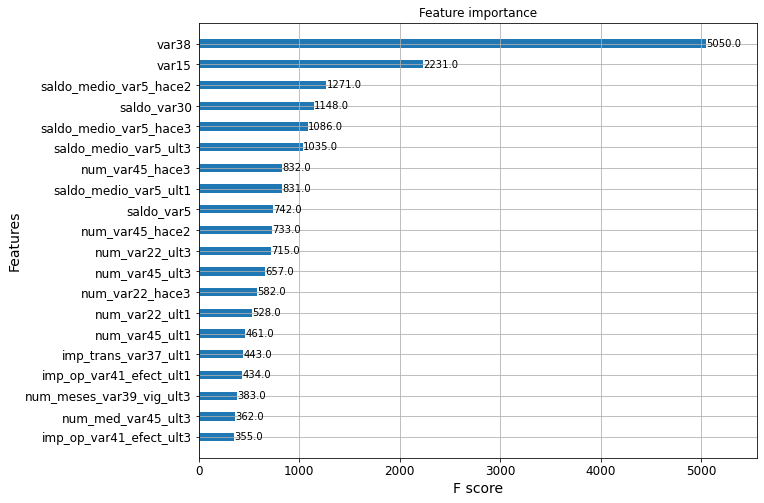

In [64]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()

XGBoost의 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순이다. 다음은 LightGBM을 이용해 모델을 학습하고 하이퍼 파라미터를 튜닝해 예측 성능을 평가해 보겠다.

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

앞의 XGBoost 예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC를 측정해 보겠다. 앞의 XGBoost 예제와 동일하게 n_estimators는 500으로 설정하고, early_stopping_rounds는 100, 평가 데이터 세트는 테스트 데이터 세트, eval_metric은 auc로 설정한다.

In [66]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.795963	valid_0's binary_logloss: 0.159288
[2]	valid_0's auc: 0.801789	valid_0's binary_logloss: 0.155038
[3]	valid_0's auc: 0.803367	valid_0's binary_logloss: 0.15185
[4]	valid_0's auc: 0.805168	valid_0's binary_logloss: 0.14961
[5]	valid_0's auc: 0.809401	valid_0's binary_logloss: 0.147695
[6]	valid_0's auc: 0.810671	valid_0's binary_logloss: 0.146234
[7]	valid_0's auc: 0.815356	valid_0's binary_logloss: 0.144877
[8]	valid_0's auc: 0.816777	valid_0's binary_logloss: 0.143783
[9]	valid_0's auc: 0.817821	valid_0's binary_logloss: 0.143084
[10]	valid_0's auc: 0.818637	valid_0's binary_logloss: 0.142272
[11]	valid_0's auc: 0.81939	valid_0's binary_logloss: 0.141623
[12]	valid_0's auc: 0.821106	valid_0's binary_logloss: 0.141043
[13]	valid_0's auc: 0.822008	valid_0's binary_logloss: 0.140628
[14]	valid_0's auc: 0.822584	valid_0's binary_logloss: 0.140198
[15]	valid_0's auc: 0.822291	valid_0's binary_logloss: 0.139909
[16]	valid_0's auc: 0.821862	valid_0's binary_loglos

[139]	valid_0's auc: 0.811524	valid_0's binary_logloss: 0.141931
[140]	valid_0's auc: 0.811309	valid_0's binary_logloss: 0.142004
[141]	valid_0's auc: 0.811321	valid_0's binary_logloss: 0.142035
[142]	valid_0's auc: 0.811275	valid_0's binary_logloss: 0.142077
[143]	valid_0's auc: 0.811453	valid_0's binary_logloss: 0.142082
ROC AUC: 0.8239


LightGBM 수행 결과 ROC AUC가 약 0.8239를 나타냈다. GridSearchCV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝을 수행해 보겠다. 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample이다.

In [70]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = XGBClassifier(n_estimators=200)

params = {'num_leaves': [32, 64],
          'max_depth': [128, 160],
          'min_child_samples': [60, 100],
          'subsample': [0.8, 1]}

# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:18:29] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:18:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:18:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:19:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:19:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:19:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:20:18] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:20:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:20:46] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:21:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:21:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:21:48] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:22:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:22:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:22:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:22:51] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:16] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:23:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:24:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:24:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:24:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:24:44] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:25:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:25:37] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:25:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:26:11] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:26:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:26:38] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:23] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:27:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:28:11] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:28:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:28:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:29:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:29:39] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:29:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:30:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:30:21] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:30:47] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:31:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:31:32] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83407	validation_1-auc:0.79558
[1]	validation_0-auc:0.84159	validation_1-auc:0.79400
[2]	validation_0-auc:0.84913	validation_1-auc:0.79596
[3]	validation_0-auc:0.85901	validation_1-auc:0.80090
[4]	validation_0-auc:0.87118	validation_1-auc:0.80424
[5]	validation_0-auc:0.87926	validation_1-auc:0.80336
[6]	validation_0-auc:0.89194	validation_1-auc:0.80204
[7]	validation_0-auc:0.89787	validation_1-auc:0.80357
[8]	validation_0-auc:0.90436	validation_1-auc:0.79359
[9]	validation_0-auc:0.90973	validation_1-auc:0.79035
[10]	validation_0-auc:0.91307	validation_1-auc:0.78692
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:31:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82586	validation_1-auc:0.78538
[1]	validation_0-auc:0.84529	validation_1-auc:0.79511
[2]	validation_0-auc:0.85699	validation_1-auc:0.79881
[3]	validation_0-auc:0.86518	validation_1-auc:0.80206
[4]	validation_0-auc:0.87640	validation_1-auc:0.80609
[5]	validation_0-auc:0.88231	validation_1-auc:0.80524
[6]	validation_0-auc:0.89213	validation_1-auc:0.80674
[7]	validation_0-auc:0.89779	validation_1-auc:0.80644
[8]	validation_0-auc:0.90268	validation_1-auc:0.80664
[9]	validation_0-auc:0.90704	validation_1-auc:0.80583
[10]	validation_0-auc:0.91034	validation_1-auc:0.80539
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:31:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82200	validation_1-auc:0.78789
[1]	validation_0-auc:0.84621	validation_1-auc:0.79938
[2]	validation_0-auc:0.85486	validation_1-auc:0.80211
[3]	validation_0-auc:0.86388	validation_1-auc:0.79885
[4]	validation_0-auc:0.87544	validation_1-auc:0.80273
[5]	validation_0-auc:0.88282	validation_1-auc:0.80076
[6]	validation_0-auc:0.88936	validation_1-auc:0.80129
[7]	validation_0-auc:0.90137	validation_1-auc:0.80321
[8]	validation_0-auc:0.90699	validation_1-auc:0.80179
[9]	validation_0-auc:0.91327	validation_1-auc:0.79907
[10]	validation_0-auc:0.91749	validation_1-auc:0.79920
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:32:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83246	validation_1-auc:0.79284
[1]	validation_0-auc:0.84292	validation_1-auc:0.79503
[2]	validation_0-auc:0.85273	validation_1-auc:0.79549
[3]	validation_0-auc:0.86582	validation_1-auc:0.79760
[4]	validation_0-auc:0.87944	validation_1-auc:0.80272
[5]	validation_0-auc:0.88708	validation_1-auc:0.80344
[6]	validation_0-auc:0.89718	validation_1-auc:0.80429
[7]	validation_0-auc:0.90561	validation_1-auc:0.80259
[8]	validation_0-auc:0.91170	validation_1-auc:0.79729
[9]	validation_0-auc:0.91576	validation_1-auc:0.79515
[10]	validation_0-auc:0.91870	validation_1-auc:0.79521
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:32:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83162	validation_1-auc:0.78458
[1]	validation_0-auc:0.84795	validation_1-auc:0.79414
[2]	validation_0-auc:0.86056	validation_1-auc:0.80078
[3]	validation_0-auc:0.87220	validation_1-auc:0.80347
[4]	validation_0-auc:0.88174	validation_1-auc:0.79910
[5]	validation_0-auc:0.89097	validation_1-auc:0.80143
[6]	validation_0-auc:0.89811	validation_1-auc:0.80325
[7]	validation_0-auc:0.90377	validation_1-auc:0.79953
[8]	validation_0-auc:0.90780	validation_1-auc:0.80231
[9]	validation_0-auc:0.91263	validation_1-auc:0.80118
[10]	validation_0-auc:0.91797	validation_1-auc:0.80081
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:32:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.82814	validation_1-auc:0.78921
[1]	validation_0-auc:0.84822	validation_1-auc:0.79506
[2]	validation_0-auc:0.86228	validation_1-auc:0.80193
[3]	validation_0-auc:0.87106	validation_1-auc:0.80037
[4]	validation_0-auc:0.87876	validation_1-auc:0.79961
[5]	validation_0-auc:0.88685	validation_1-auc:0.79818
[6]	validation_0-auc:0.89273	validation_1-auc:0.79846
[7]	validation_0-auc:0.90156	validation_1-auc:0.80078
[8]	validation_0-auc:0.91221	validation_1-auc:0.80089
[9]	validation_0-auc:0.91718	validation_1-auc:0.79583
[10]	validation_0-auc:0.92070	validation_1-auc:0.79186
[11]	validation_0-auc:0

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[20:33:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "min_child_samples", "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.83555	validation_1-auc:0.78965
[1]	validation_0-auc:0.86116	validation_1-auc:0.79984
[2]	validation_0-auc:0.87807	validation_1-auc:0.80245
[3]	validation_0-auc:0.89103	validation_1-auc:0.80022
[4]	validation_0-auc:0.90320	validation_1-auc:0.80427
[5]	validation_0-auc:0.91417	validation_1-auc:0.80204
[6]	validation_0-auc:0.92510	validation_1-auc:0.80400
[7]	validation_0-auc:0.93772	validation_1-auc:0.80533
[8]	validation_0-auc:0.94572	validation_1-auc:0.80391
[9]	validation_0-auc:0.95302	validation_1-auc:0.79970
[10]	validation_0-auc:0.95964	validation_1-auc:0.79975
[11]	validation_0-auc:0

해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출해 보겠다.

In [71]:
lgbm_clf = LGBMClassifier(n_estimators=100, num_leaves=32, subsample=0.8, min_child_samples=60,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
             verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.795127	valid_0's binary_logloss: 0.159495
[2]	valid_0's auc: 0.801362	valid_0's binary_logloss: 0.15504
[3]	valid_0's auc: 0.802469	valid_0's binary_logloss: 0.151861
[4]	valid_0's auc: 0.807355	valid_0's binary_logloss: 0.14948
[5]	valid_0's auc: 0.813597	valid_0's binary_logloss: 0.147361
[6]	valid_0's auc: 0.815524	valid_0's binary_logloss: 0.145802
[7]	valid_0's auc: 0.818905	valid_0's binary_logloss: 0.144503
[8]	valid_0's auc: 0.818653	valid_0's binary_logloss: 0.143449
[9]	valid_0's auc: 0.820379	valid_0's binary_logloss: 0.142627
[10]	valid_0's auc: 0.821353	valid_0's binary_logloss: 0.141967
[11]	valid_0's auc: 0.82154	valid_0's binary_logloss: 0.141404
[12]	valid_0's auc: 0.821374	valid_0's binary_logloss: 0.140918
[13]	valid_0's auc: 0.82085	valid_0's binary_logloss: 0.140569
[14]	valid_0's auc: 0.820801	valid_0's binary_logloss: 0.14023
[15]	valid_0's auc: 0.821073	valid_0's binary_logloss: 0.139867
[16]	valid_0's auc: 0.820768	valid_0's binary_logloss:

LightGBM의 경우 테스트 데이터 세트에서 ROC-AUC가 약 0.8234로 측정됐다.